In [24]:
import numpy as np

import networkx as nx
import matplotlib.pyplot as plt

import os.path as op
import sys
sys.path.append("../")

from src import regmod
from src import utils
from src import solver

## Synthetic Example

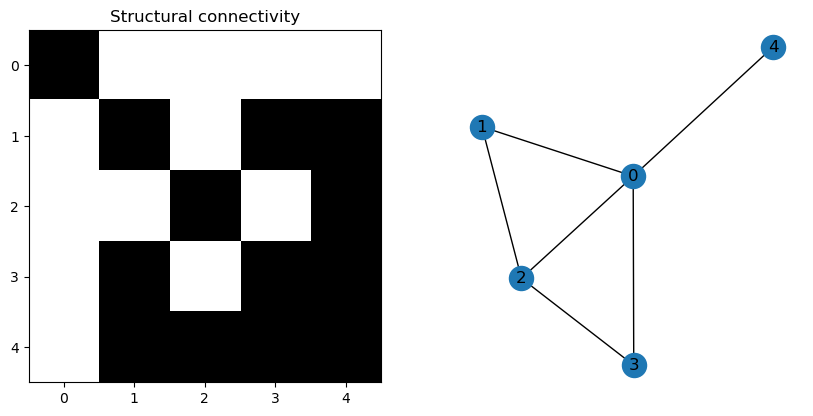

In [25]:
path_to_data = "../resources"

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

filename = "adjacency_synthetic.pkl"

adj = utils.load(op.join(path_to_data, filename))
adj -= np.diag(np.diag(adj))

axes[0].imshow(adj, cmap='gray')
axes[0].set_title('Structural connectivity')
toy_graph = nx.Graph(adj)
nx.draw(toy_graph, ax=axes[1], with_labels=True)

### Example of a forward pass

  0%|          | 0/20 [00:00<?, ?it/s]

Early stopping !


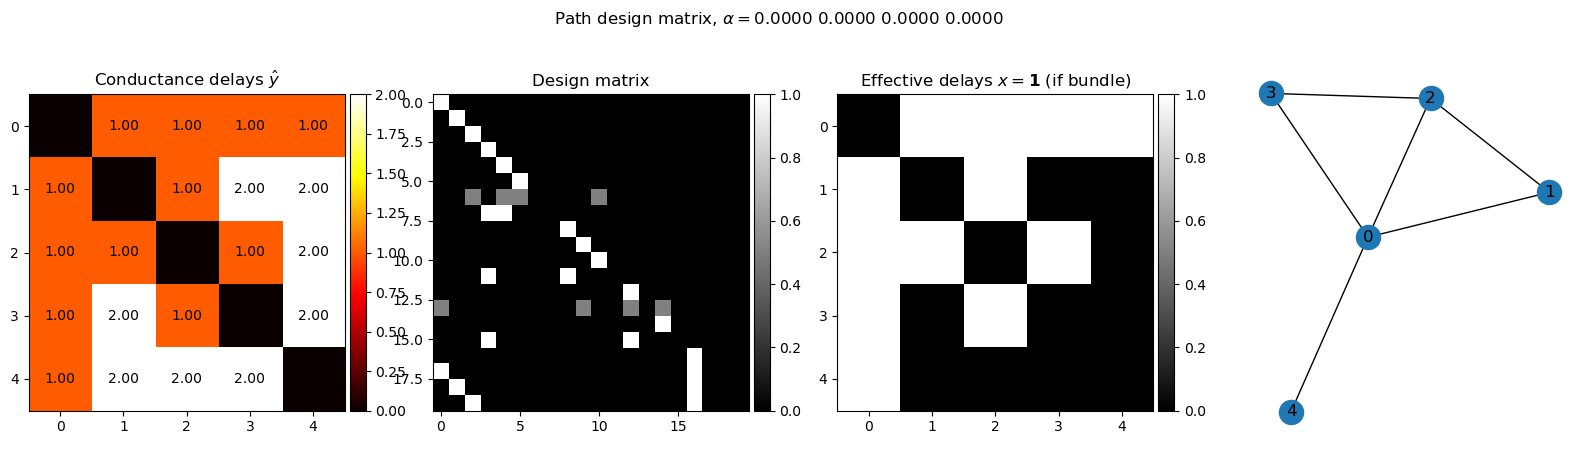

In [26]:
max_path_depth = 4

multi_hops_design = regmod.get_path_matrices(adj, max_path_depth)

a = 0
# Computes the alpha vector as alpha_n = a^n
alpha = [a**(i+1) for i in range(max_path_depth)]
#alpha = a

design_shortest = regmod.combine_paths_matrices(multi_hops_design, alpha=alpha)
design_shortest = regmod.build_design_shortest(adj, n_subopt=1, alpha=a)
design_model = design_shortest

y_pred_mat = regmod.predict_conduction_delays(design_model, adj, invert_weights=False)

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(rf"Path design matrix, $\alpha=$"+" ".join([f"{a:1.4f}" for a in list(alpha)]))
axes[0].imshow(y_pred_mat, cmap='hot')
axes[0].set_title("Conductance delays $\hat{y}$")
utils.add_cbar(fig, axes[0])
utils.annotate_heatmap(fig, axes[0], y_pred_mat, adapt_color=0.6)

axes[1].imshow(design_model, cmap='gray')#, vmax=y_pred_mat.max())
axes[1].set_title("Design matrix")
utils.add_cbar(fig, axes[1])

axes[2].imshow(adj, cmap='gray')#, vmax=y_pred_mat.max())
axes[2].set_title("Effective delays $x=\mathbf{1}$ (if bundle)")
utils.add_cbar(fig, axes[2])

nx.draw(toy_graph, ax=axes[3], with_labels=True)

### Sanity check using the Pseudo-inverse solution

In [27]:
max_path_depth = 4
multi_hops_design = regmod.get_path_matrices(adj, max_path_depth)

  0%|          | 0/20 [00:00<?, ?it/s]

In [28]:
x_ground = utils.remove_diagonal_entries(adj).flatten()

a = 0
# Computes the alpha vector as alpha_n = a^n
alpha = solver.torch.tensor([a**(i+1) for i in range(max_path_depth)])

design_model = solver.combine_paths_matrices_torch(solver.torch.tensor(multi_hops_design), alpha=alpha)
design_model = solver.torch.tensor(design_shortest)
y_pred = solver.forward(design_model, solver.torch.tensor(x_ground)).numpy()

In [29]:
x_opt = solver.pseudo_inverse(y_pred, a_design=design_model.numpy())
y_est = design_model.numpy() @ x_opt
loss = np.linalg.norm(y_est - y_pred)

(<Figure size 1000x500 with 4 Axes>,
 <Axes: title={'center': 'Estimated Effective delays w/ loss=0.0'}>)

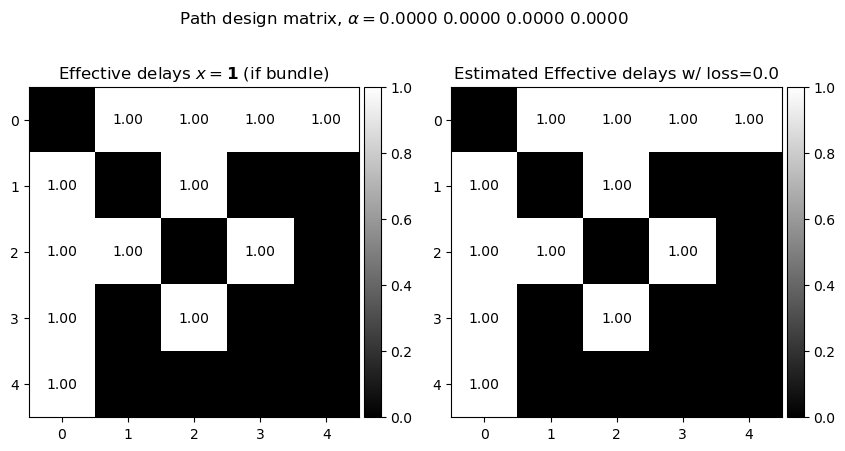

In [30]:
x_ground_mat = utils.add_diagonal_entries(x_ground.reshape(adj.shape[0], adj.shape[1]-1))
x_pred_mat = utils.add_diagonal_entries(x_opt.reshape(adj.shape[0], adj.shape[1]-1))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
fig.suptitle(rf"Path design matrix, $\alpha=$"+" ".join([f"{a:1.4f}" for a in list(alpha)]))
axes[0].imshow(x_ground_mat, cmap='gray')
axes[0].set_title("Effective delays $x=\mathbf{1}$ (if bundle)")
utils.add_cbar(fig, axes[0])
utils.annotate_heatmap(fig, axes[0], x_ground_mat, adapt_color=0.6)

axes[1].imshow(x_pred_mat, cmap='gray')#, vmax=y_pred_mat.max())
axes[1].set_title(f"Estimated Effective delays w/ loss={np.round(loss,4)}")
utils.add_cbar(fig, axes[1])
utils.annotate_heatmap(fig, axes[1], np.round(x_pred_mat,4), adapt_color=0.6)

# F-tract Example

Contents:
- Sanity check 
    - generating measured delay by considering only 1s delay for all bundles
    - verifying that the solver regresses back the only 1 delays

- Regressing conductance delays

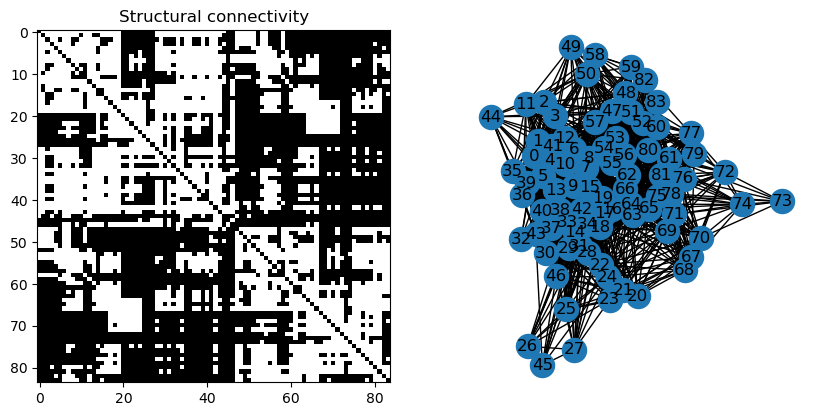

In [32]:
path_to_data = "../resources"

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

filename = "adjacency_atlas.pkl"

adj = utils.load(op.join(path_to_data, filename))
# TODO + NOTE: temporary truncation to remove (by michael)
adj = adj[:84, :84] 
adj -= np.diag(np.diag(adj))

axes[0].imshow(adj, cmap='gray')
axes[0].set_title('Structural connectivity')
toy_graph = nx.Graph(adj)
nx.draw(toy_graph, ax=axes[1], with_labels=True)

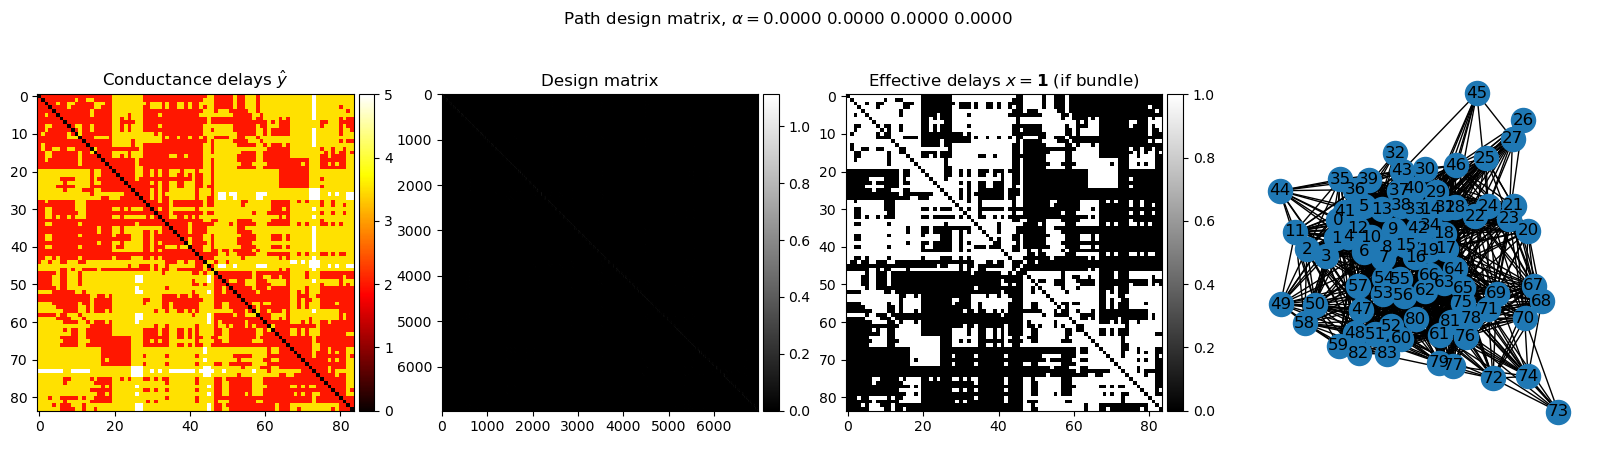

In [33]:
max_path_depth = 3

#a = 0
# Computes the alpha vector as alpha_n = a^n
#alpha = [a**(i+1) for i in range(max_path_depth)]

design_shortest = regmod.build_design_shortest(adj, n_subopt=1, alpha=0.5)

y_pred_mat = regmod.predict_conduction_delays(design_shortest, adj, invert_weights=False)

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(rf"Path design matrix, $\alpha=$"+" ".join([f"{a:1.4f}" for a in list(alpha)]))
axes[0].imshow(y_pred_mat, cmap='hot', interpolation=None)
axes[0].set_title("Conductance delays $\hat{y}$")
utils.add_cbar(fig, axes[0])
#utils.annotate_heatmap(fig, axes[0], y_pred_mat, adapt_color=0.6)

axes[1].imshow(design_shortest, cmap='gray')#, vmax=y_pred_mat.max())
axes[1].set_title("Design matrix")
utils.add_cbar(fig, axes[1])

axes[2].imshow(adj, cmap='gray')#, vmax=y_pred_mat.max())
axes[2].set_title("Effective delays $x=\mathbf{1}$ (if bundle)")
utils.add_cbar(fig, axes[2])

nx.draw(toy_graph, ax=axes[3], with_labels=True)

### Investigating the influence of `rcond` parameter (convergence of SVD - reduced to 45 nodes)

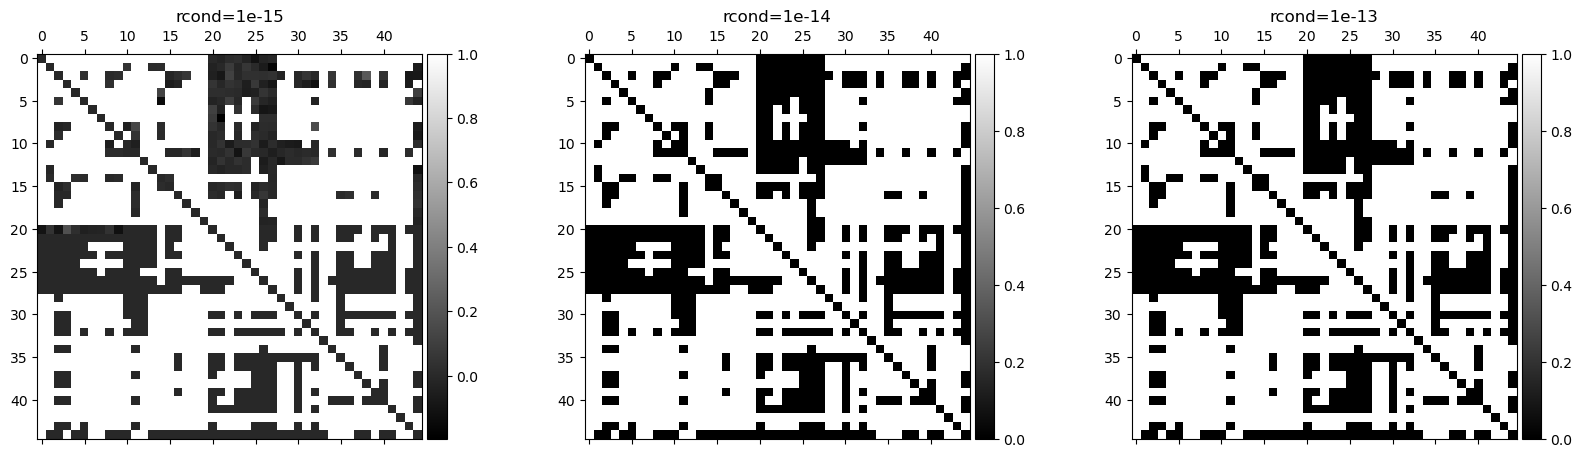

In [35]:
n_reduced = 50
reduced_adj = adj[:n_reduced][:, :n_reduced]

design_shortest = regmod.build_design_shortest(reduced_adj, n_subopt=1, alpha=a)
design_model = solver.torch.tensor(design_shortest)

x_ground = utils.remove_diagonal_entries(reduced_adj).flatten()
y_pred = solver.forward(design_model, solver.torch.tensor(x_ground)).numpy()

design_shortest = regmod.build_design_shortest(reduced_adj)
design_model = solver.torch.tensor(design_shortest)

all_rconds = [1e-15, 1e-14, 1e-13]

all_x_opts = np.zeros((len(all_rconds), len(reduced_adj), len(reduced_adj)))

for i, rcond in enumerate(all_rconds):
    x_opt = solver.pseudo_inverse(y_pred, a_design=design_model, rcond=rcond)
    all_x_opts[i] = utils.add_diagonal_entries(x_opt.reshape(reduced_adj.shape[0], reduced_adj.shape[1]-1))

fig, axes = plt.subplots(ncols=len(all_rconds), figsize=(20, 5))

for ax, mat, rcond in zip(axes, all_x_opts, all_rconds):
    ax.set_title(f"rcond={rcond}")
    ax.matshow(mat, cmap='gray')
    utils.add_cbar(fig, ax)

### Sanity check

In [36]:
a = 0.5
# Computes the alpha vector as alpha_n = a^n
# alpha = solver.torch.tensor([a**(i+1) for i in range(max_path_depth)])

design_model = solver.torch.tensor(regmod.build_design_shortest(adj, n_subopt=1, alpha=a))

x_ground = utils.remove_diagonal_entries(adj).flatten()
y_pred = solver.forward(design_model, solver.torch.tensor(x_ground)).numpy()

In [37]:
x_opt = solver.pseudo_inverse(y_pred, a_design=design_model.numpy(), rcond=1e-10)
y_est = design_model.numpy() @ x_opt
loss = np.linalg.norm(y_est - y_pred)

(<Figure size 1000x500 with 4 Axes>,
 <Axes: title={'center': 'Estimated Effective delays w/ loss=0.0'}>)

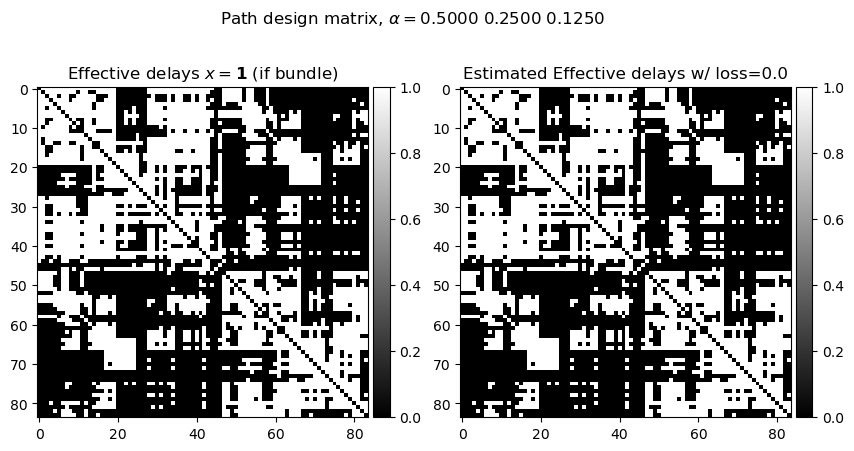

In [38]:
x_ground_mat = utils.add_diagonal_entries(x_ground.reshape(adj.shape[0], adj.shape[1]-1))
x_pred_mat = utils.add_diagonal_entries(x_opt.reshape(adj.shape[0], adj.shape[1]-1))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
fig.suptitle(rf"Path design matrix, $\alpha=$"+" ".join([f"{a:1.4f}" for a in list(alpha)]))
axes[0].imshow(x_ground_mat, cmap='gray')
axes[0].set_title("Effective delays $x=\mathbf{1}$ (if bundle)")
utils.add_cbar(fig, axes[0])
# utils.annotate_heatmap(fig, axes[0], x_ground_mat, adapt_color=0.6)

axes[1].imshow(x_pred_mat, cmap='gray')#, vmax=y_pred_mat.max())
axes[1].set_title(f"Estimated Effective delays w/ loss={np.round(loss,4)}")
utils.add_cbar(fig, axes[1])
# utils.annotate_heatmap(fig, axes[1], np.round(x_pred_mat,4), adapt_color=0.6)

Text(0.5, 1.0, 'Difference (>10%) map between predicted and ground truth matrices')

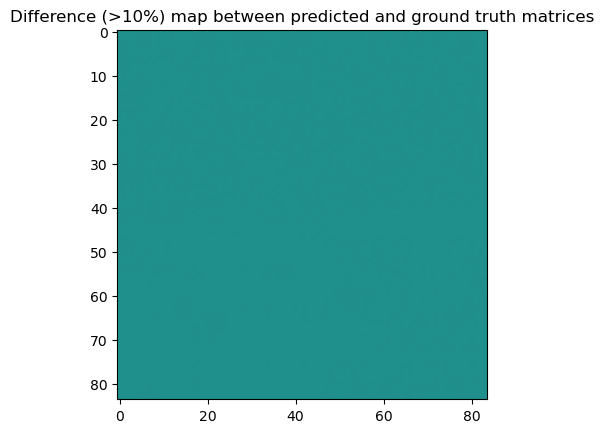

In [39]:
fig, ax = plt.subplots()
#ax.imshow(np.abs(x_pred_mat - x_ground_mat) > 0.1)
ax.imshow(x_pred_mat - x_ground_mat, vmin=-1e-5, vmax=1e-5)
ax.set_title('Difference (>10%) map between predicted and ground truth matrices')

## From conductance delay

In [40]:
y_ground_mat = utils.load("../resources/conductance-delay_Lausanne2008_33.pkl")
y_ground_mat = np.nan_to_num(y_ground_mat['median'])

y_ground = utils.remove_diagonal_entries(y_ground_mat).flatten()

### Distribution of conduction delay

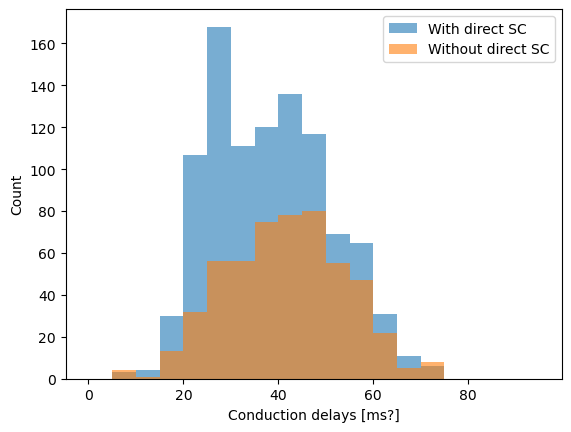

In [41]:
cond_w_direct = y_ground[x_ground>0]
cond_wout_direct = y_ground[x_ground==0]

nbins=np.arange(0, 100, 5)
plt.hist(cond_w_direct[cond_w_direct>0], bins=nbins, alpha=0.6, label='With direct SC')
plt.hist(cond_wout_direct[cond_wout_direct>0], bins=nbins, alpha=0.6, label='Without direct SC')
plt.xlabel("Conduction delays [ms?]")
plt.ylabel("Count")
plt.legend()

#plt.boxplot([cond_w_direct[cond_w_direct>0], cond_wout_direct[cond_wout_direct>0]])
#plt.xticks([1, 2], ['Direct SC', 'No direct SC'])
#plt.ylabel('Conduction delays')

## Finding the optimal effective delay $x$

In [42]:
x_opt = solver.pseudo_inverse(y_ground, a_design=design_model, rcond=1e-10)
y_est = design_model @ x_opt
loss = np.linalg.norm(y_est - y_ground)

(<Figure size 1500x500 with 6 Axes>,
 <Axes: title={'center': 'Clipped $\\hat y$'}>)

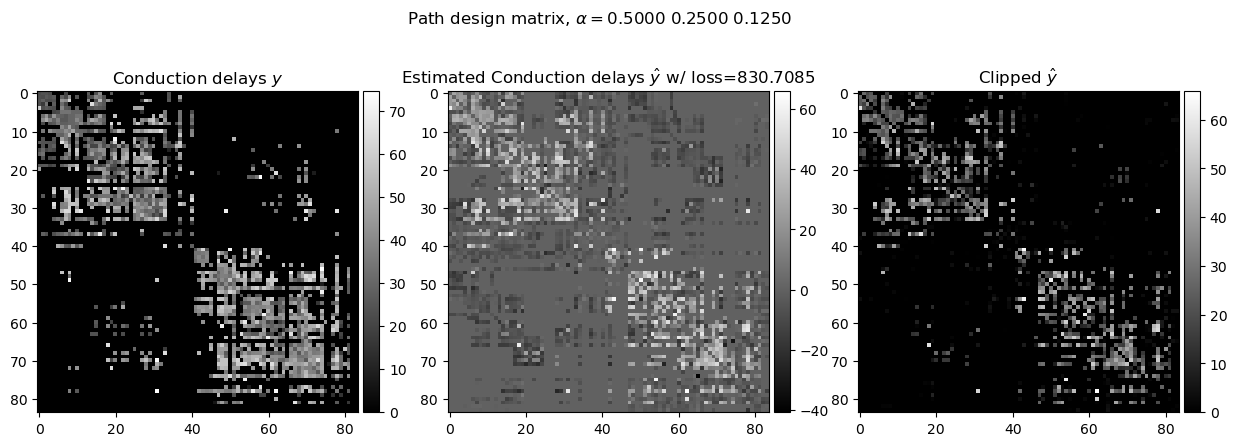

In [43]:
x_pred_mat = utils.add_diagonal_entries(x_opt.reshape(adj.shape[0], adj.shape[1]-1))

fig, axes = plt.subplots(ncols=3, figsize=(15, 5))
fig.suptitle(rf"Path design matrix, $\alpha=$"+" ".join([f"{a:1.4f}" for a in list(alpha)]))

axes[0].imshow(y_ground_mat, cmap='gray')
axes[0].set_title(f"Conduction delays $y$")
utils.add_cbar(fig, axes[0])
# utils.annotate_heatmap(fig, axes, np.round(x_pred_mat,4), adapt_color=0.6)

axes[1].imshow(x_pred_mat, cmap='gray')
axes[1].set_title(f"Estimated Conduction delays $\hat y$ w/ loss={np.round(loss,4)}")
utils.add_cbar(fig, axes[1])

axes[2].imshow(x_pred_mat, cmap='gray', vmin=0)
axes[2].set_title(f"Clipped $\hat y$")
utils.add_cbar(fig, axes[2])

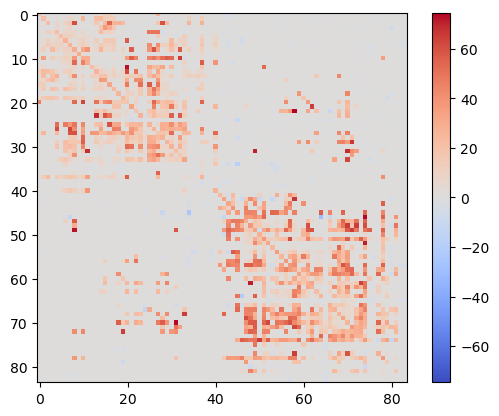

In [44]:
diff = y_ground_mat - np.clip(x_pred_mat, a_min=0, a_max=None)
maxval = np.abs(diff).max()
plt.imshow(diff, vmin=-maxval, vmax=maxval, cmap="coolwarm")
plt.colorbar()

# Visualize the influence of $\alpha$

In [45]:
n_reduced = 50

y_ground = utils.remove_diagonal_entries(y_ground_mat[:n_reduced][:, :n_reduced]).flatten()

reduced_adj = adj[:n_reduced][:, :n_reduced]

n_alphas=10
alphas = np.linspace(0, 2, n_alphas)

losses = np.zeros_like(alphas)
all_sol = np.zeros((len(alphas), reduced_adj.shape[0], reduced_adj.shape[1]))

for a_i, a in enumerate(alphas):
    design_shortest = solver.torch.tensor(regmod.build_design_shortest(reduced_adj, n_subopt=1, alpha=a))

    x_opt = solver.pseudo_inverse(y_ground, a_design=design_shortest, rcond=1e-10)
    all_sol[a_i] = utils.add_diagonal_entries(x_opt.reshape(reduced_adj.shape[0], reduced_adj.shape[1]-1))

    y_est = design_shortest @ x_opt
    losses[a_i] = np.linalg.norm(y_est - y_ground)


(<Figure size 1800x500 with 5 Axes>,
 <Axes: title={'center': 'Clipped effective delays $x^*$ for $\\alpha=2.0$'}>)

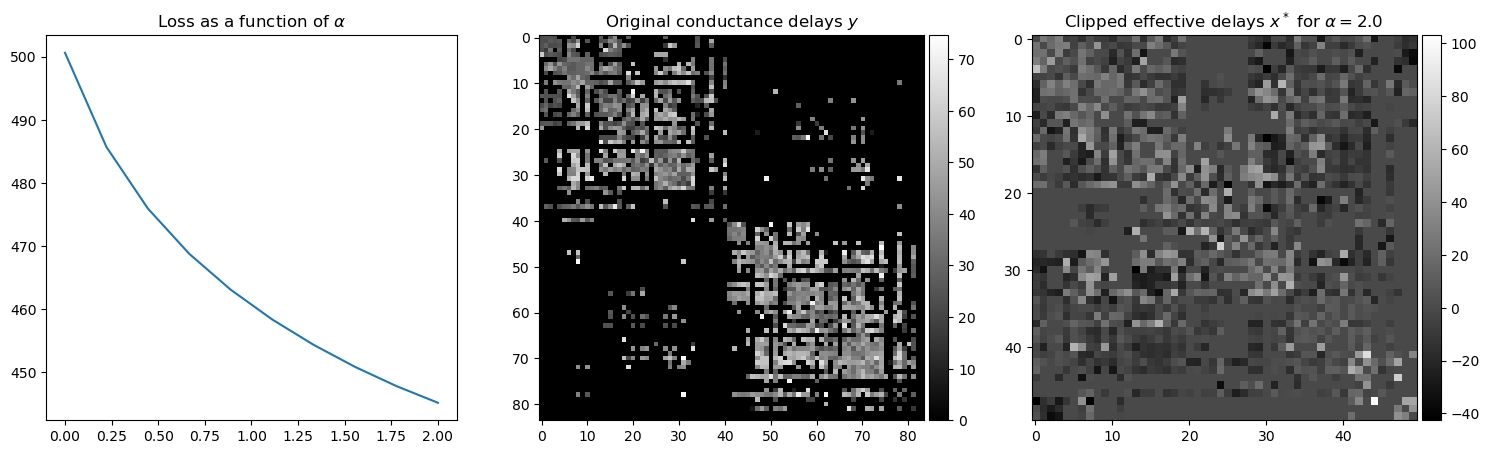

In [46]:
fig, axes = plt.subplots(ncols=3, figsize=(18, 5))

axes[0].plot(alphas, losses)
axes[0].set_title(r"Loss as a function of $\alpha$")

axes[1].imshow(y_ground_mat, cmap='gray')
axes[1].set_title(r"Original conductance delays $y$")
utils.add_cbar(fig, axes[1])

axes[2].imshow(all_sol[np.argmin(losses)], cmap='gray')
axes[2].set_title(rf"Clipped effective delays $x^*$ for $\alpha={alphas[np.argmin(losses)]}$")
utils.add_cbar(fig, axes[2])